## Initialization

In [3]:
import os, sys
import torch
import transformers
from torch.utils.data import DataLoader, SequentialSampler
import torch.nn as nn
import argparse
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from rouge_score import rouge_scorer
from sklearn.metrics import precision_recall_curve, auc
import seaborn as sns
from itertools import count
from scipy.signal import find_peaks
from findpeaks import findpeaks
import scipy.signal
from rouge_score import rouge_scorer

/opt/conda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import sys
sys.path.append("/home/divy/FiD")

In [10]:
import src
from src.data import load_data
from src.evaluation import ems
import src.model

## Load data

Try out NQ with NQ pretrained checkpoint

In [14]:
nq_path =  "/mnt/disks/external_mounted_disk/datasets/NQ/NQ/test.json"
compose_path = "/mnt/disks/external_mounted_disk/datasets/compose_FiD/compose_fid_qa/dev.json"

one_correct_path = "/mnt/disks/external_mounted_disk/datasets/compose_FiD/compose_fid_qa/one_correct.json"
one_correct_noanswer_path = "/mnt/disks/external_mounted_disk/datasets/compose_FiD/compose_fid_qa/one_correct_noanswer.json"

none_correct_path = "/mnt/disks/external_mounted_disk/datasets/compose_FiD/compose_fid_qa/none_correct.json"
movant_test = "/home/divy/casetext-ml-datasets/fid_reader_distill_question_data/movant_fid_formatted_noscores.json"


In [6]:
# uncorrupted examples
eval_examples = load_data(
                            compose_path,
                            global_rank=0,
                            world_size=1,
                            )


# examples with 4 nonsensical support, one correct
one_correct_examples = load_data(
                            one_correct_noanswer_path,
                            global_rank=0,
                            world_size=1,
                            )

# all 5 support passages are nonsensical
none_correct_examples = load_data(
                            none_correct_path,
                            global_rank=0,
                            world_size=1,
                            )

# movant_examples = load_data(
#                             movant_test,
#                             global_rank=0,
#                             world_size=1,
#                             )

nq_examples = load_data(
     nq_path,
    global_rank=0,
    world_size=1
)


In [7]:
# setting to 5 so as to keep it short for testing
n_passages = 25

In [8]:
nq_dataset = src.data.Dataset(nq_examples, n_passages)
nq_sampler = SequentialSampler(nq_dataset)
len(nq_dataset)

3610

In [9]:
eval_dataset_dev = src.data.Dataset(eval_examples, n_passages)
sampler_dev = SequentialSampler(eval_dataset_dev)
len(eval_dataset_dev)

386

In [10]:
tokenizer = transformers.T5Tokenizer.from_pretrained('t5-base')
collator = src.data.Collator(200, tokenizer, answer_maxlength=-1)

In [11]:
dataloader_dev = DataLoader(eval_dataset_dev,
        sampler=sampler_dev,
        batch_size=1,
        drop_last=False,
        num_workers=10,
        collate_fn=collator
    )

In [13]:
dataloader_oc = DataLoader(one_correct_dataset,
        sampler=sampler_one_correct,
        batch_size=1,
        drop_last=False,
        num_workers=10,
        collate_fn=collator
    )

In [14]:
dataloader_nc = DataLoader(nq_dataset,
        sampler=nq_sampler,
        batch_size=1,
        drop_last=False,
        num_workers=10,
        collate_fn=collator
    )

NameError: name 'collator' is not defined

In [88]:
dataloader_nq = DataLoader(nq_dataset,
        sampler=nq_sampler,
        batch_size=1,
        drop_last=False,
        num_workers=10,
        collate_fn=collator
    )

## Load model

In [12]:
model_name = 't5-base'
model_class = src.model.FiDT5

In [13]:
load_path = "/home/divy/FiD/model_ckpts/test_experiment_large_fid_qa_compose"
# load_path = "/home/divy/FiD/nq_reader_base"
model = model_class.from_pretrained(load_path)

In [14]:
model = model.to('cuda')

### load an example input, generated output and ground truth output

In [15]:
cherry_picked_example = 0
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

In [16]:
for i, batch in enumerate(dataloader_dev):
    (idx, labels, _, context_ids, context_mask) = batch
    
    if i == cherry_picked_example:
        
        generated_output, log_prob = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                do_sample=False,
                max_length=150,
                top_p=0.9,
                temperature=1.0,
                output_confidence=True,

            )
        
        input_scores = model.obtain_input_scores(
            labels.cuda(),
            context_ids.cuda(),
            context_mask.cuda(),
            tokenizer
        )
        
        print(input_scores)
                
        softmax = nn.Softmax(dim=0)
        
        softmaxed_input_scores = softmax(torch.tensor(input_scores))
        print(softmaxed_input_scores)
    
        break

[-1.1517304, -2.1820424, -0.61390436, -0.59517896, -0.79952306, -1.5358268, -0.9595901, -0.34922308, -0.4930195, -0.5756873, -1.6418923, -2.2678573, -1.6418923, -2.2678573]
tensor([0.0627, 0.0224, 0.1073, 0.1094, 0.0892, 0.0427, 0.0760, 0.1399, 0.1211,
        0.1115, 0.0384, 0.0205, 0.0384, 0.0205])


In [17]:
for i, batch in enumerate(dataloader_dev):
    (idx, labels, k, context_ids, context_mask) = batch
    
    if i == cherry_picked_example:
        
        print(idx)
        print(k)
        print(context_ids.shape)
        
        for j in range(context_ids.shape[1]):

            print("====")
            print(j)
            context = tokenizer.decode(context_ids[0][j])
            print(context)
            
            
        print("")
        print("")
        print("generated answer:")
        # generated_output = model.generate(
        #         input_ids=context_ids.cuda(),
        #         attention_mask=context_mask.cuda(),
        #         max_length=50
        #     ).cpu()
        
        generated_output, log_prob = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                do_sample=True,
                max_length=150,
                top_p=0.9,
                temperature=1.0,
                output_confidence=True,
                
            )
        
        # generated_output = generated_output.cpu()
        
        # print(generated_output.sequences)
        # print(generated_output.scores)
        
        # print(generated_output)
        # print(len(generated_output[0]))
        
        human_readable_generated_output = tokenizer.decode(generated_output[0], skip_special_tokens=True)
        print(human_readable_generated_output)
        
        print("")
        print("")
        print("ground truth answer:")
        ground_truth_answer = tokenizer.decode(labels[0], skip_special_tokens=True)
        print(ground_truth_answer)
        
        print("")
        print("log_prob")
        print(log_prob)
        
        print("")
        print("rouge score")
        rouge_score = scorer.score(ground_truth_answer, human_readable_generated_output)['rougeL'].fmeasure
        print(rouge_score)
        break
    
        


tensor([0])
tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]])
torch.Size([1, 14, 200])
====
0
question: When does the statute of limitations period begin for a plaintiff who experiences a continuing practice and policy of discrimination? title: context: Under this approach, if a plaintiff experienced a continuous policy or practice of discrimination, the continuing-violation doctrine delays the commencement of the statute-of-limitations period until the occurrence of the last discriminatory act in furtherance of that discriminatory practice.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

## compute g_{q,p} / max-pool attention matrices

### Compute a potential score

In [19]:
def subfinder(mylist, pattern):
    matches = []
    for i in range(len(mylist)):
        if mylist[i] == pattern[0] and mylist[i:i+len(pattern)] == pattern:
            matches.append((i + len(pattern), pattern))
    return matches

In [20]:
with open("../numpy_drops/rouge_similarity_answers_dev", "rb") as f:
    rouge_matches = pickle.load(f)


In [22]:
high_rouge_similarities = [el for el in rouge_matches if el[2] >= 0.9]
high_rouge_similarity_indices = [el[3] for el in high_rouge_similarities]

In [24]:
high_rouge_similarities

[('An arbitration agreement that gives one party the sole power to select the arbitrator is substantively unconscionable.',
  'An arbitration agreement that gives one party the sole power to select the arbitrator is substantively unconscionable.',
  1.0,
  2),
 ('A defendant who obtains a dismissal can be considered the prevailing party.\xa0',
  'A defendant who obtains a dismissal can be considered the prevailing party.',
  1.0,
  19),
 ('If a contract provides for attorney fees, that provision is construed to apply to the entire contract, unless each party was represented by counsel in the negotiation and execution of the contract, and the fact of that representation is specified in the contract.',
  'If a contract provides for attorney fees, it is assumed that the provision applies to the entire contract, unless each party was represented by counsel in the negotiation and execution of the contract and the fact of that representation is specified in the contract.',
  0.91954022988505

In [23]:
low_rouge_similarities = [el for el in rouge_matches if el[2] <= 0.3]
low_rouge_similarity_indices = [el[3] for el in low_rouge_similarities]

len(low_rouge_similarity_indices)

28

In [25]:
min_savgols_low_similarity = []
max_savgols_low_similarity = []

min_savgols_high_similarity = []
max_savgols_high_similarity = []

passage_max_scores = []
passage_mean_scores = []

rouge_scores = []
log_probs = []

# set criterion on the number of passages that must be used
topk_passages = 5
topk_passage_means = []
topk_passage_stdevs = []


In [26]:
for i, batch in tqdm(enumerate(dataloader_dev)):
    (idx, labels, _, context_ids, context_mask) = batch
            
    # print(i)
    
    # if i in low_rouge_similarity_indices:
    
    print(i)
    with torch.no_grad():

        generated_output, log_prob = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                do_sample=False,
                max_length=150,
                top_p=0.9,
                temperature=1.0,
                output_confidence=True,

            )

        model_forward = model.forward(
            input_ids=context_ids.cuda(),
            attention_mask=context_mask.cuda(),
            # decoder_input_ids=labels.cuda(),
            decoder_input_ids=generated_output.cuda(),
            output_attentions=True,
            output_unnormalized_attentions=True,
        )

    cross_attentions = model_forward.cross_attentions
    stacked_forward_attentions = torch.cat(cross_attentions, dim=0)
    msk = torch.reshape(context_mask, (1, context_mask.shape[1]*context_mask.shape[2])).cuda()

    masked_stacked_forward_attentions = stacked_forward_attentions.masked_fill(msk == False, -10000.0)

    avg_attn_matrix = torch.mean(masked_stacked_forward_attentions, dim=(0, 1)).cpu()
    context_ids_reshaped = torch.reshape(context_ids, (1, context_ids.shape[1]*context_ids.shape[2]))
    all_input_tokens = tokenizer.convert_ids_to_tokens(context_ids_reshaped[0])

    start_pattern = ['▁title', ':', '▁context', ':']
    end_pattern = ['</s>']

    start_index_pattern = subfinder(all_input_tokens, start_pattern)
    end_index_pattern = subfinder(all_input_tokens, end_pattern)

    start_indices = [el[0] for el in start_index_pattern]
    end_indices = [el[0] for el in end_index_pattern]

    relevant_ranges = [(start_index, end_index - 1) for start_index, end_index in zip(start_indices, end_indices)]
    print(relevant_ranges)
    
    mean_savgols = []
    for relevant_range in relevant_ranges:
        spliced_attn_matrix = avg_attn_matrix[:, relevant_range[0]:relevant_range[1]]

        maxpool = torch.max(spliced_attn_matrix, axis=0).values.cpu().numpy()
        minpool = torch.min(spliced_attn_matrix, axis=0).values.cpu().numpy()

        m = maxpool
        # m = maxpool - minpool
        try:
            savgol = scipy.signal.savgol_filter(m, 10, 3)

        except ValueError:
            try:
                savgol = scipy.signal.savgol_filter(m, 5, 3)

            except ValueError:
                try:
                    savgol = scipy.signal.savgol_filter(m, 3, 2)

                except ValueError:
                    try:
                        savgol = scipy.signal.savgol_filter(m, 2, 1)

                    except ValueError:
                        try:
                            savgol = scipy.signal.savgol_filter(m, 1, 0)

                        except ValueError:
                            savgol = [-float('inf')]

        mean_savgol = np.mean(savgol)

        mean_savgols.append(mean_savgol)

    passage_max_scores.append(max(mean_savgols))
    passage_mean_scores.append(np.mean(mean_savgols))
    print(mean_savgols)
    
    rouge_scores.append(rouge_matches[i][2])
    log_probs.append(log_prob)
    print(max(mean_savgols), min(mean_savgols))
    print(rouge_matches[i][2])
    
    mean_savgols_np = np.array(mean_savgols)
    topk_means_savgols = np.partition(mean_savgols_np, -topk_passages)[-topk_passages:]
    
    print(topk_means_savgols)
    
    mean_topk_mean_savgols = np.mean(topk_means_savgols)
    std_topk_mean_savgols = np.std(topk_means_savgols)
    
    print(std_topk_mean_savgols)
    
    topk_passage_means.append(mean_topk_mean_savgols)
    topk_passage_stdevs.append(std_topk_mean_savgols)
  


0it [00:00, ?it/s]

0


1it [00:02,  2.51s/it]

[(30, 88), (230, 271), (430, 476), (630, 690), (830, 884), (1030, 1070), (1230, 1285), (1430, 1482), (1630, 1684), (1830, 1888), (2030, 2199), (2230, 2312), (2430, 2599), (2630, 2712)]
[0.09722672, 0.035961956, 1.385124, 0.8521029, 1.0795133, 0.42338902, 0.95472276, 1.4571953, 1.2572294, 1.0908605, -1.2826912, -1.2958845, -1.2826912, -1.2958845]
1.4571953 -1.2958845
0.8266666666666667
[1.0795133 1.0908605 1.2572294 1.385124  1.4571953]
0.15202127
1


2it [00:05,  2.78s/it]

[(36, 59), (236, 261), (436, 461), (636, 657), (836, 863), (1036, 1059), (1236, 1259), (1436, 1472), (1636, 1675), (1836, 1867), (2036, 2098), (2236, 2307), (2436, 2599)]
[-1.5983444, -1.6664832, -1.6664832, -1.2532346, -1.5556364, -1.6425496, -1.6425496, -1.1384568, -1.8597382, -1.714814, -0.50836825, 0.6989463, -0.36014405]
0.6989463 -1.8597382
0.5074626865671642
[-1.2532346  -1.1384568  -0.50836825  0.6989463  -0.36014405]
0.69732934
2


3it [00:06,  2.13s/it]

[(30, 79), (135, 167), (240, 267), (345, 372), (450, 482), (555, 629), (660, 695), (765, 792), (870, 905), (975, 1037), (1080, 1146), (1185, 1241), (1290, 1351), (1395, 1461), (1500, 1561), (1605, 1671), (1710, 1776), (1815, 1871)]
[-1.506421, -1.857425, -1.5619498, -2.0615804, -1.9215717, -1.2851454, -1.159129, -1.4848357, -1.7595612, -1.4084375, -1.5848768, -1.005441, -1.006616, -1.5848768, -1.006616, -1.5848768, -1.5848768, -1.005441]
-1.005441 -2.0615804
1.0
[-1.159129 -1.006616 -1.006616 -1.005441 -1.005441]
0.061242476
3


4it [00:09,  2.15s/it]

[(19, 54), (219, 276), (419, 471), (619, 639), (819, 840), (1019, 1051), (1219, 1259), (1419, 1455), (1619, 1659), (1819, 1860), (2019, 2199), (2219, 2399)]
[-0.806493, -1.1690782, -1.314888, -1.2788199, -0.9131406, -1.7853014, -1.7238843, -2.0996246, -1.8583053, -1.1964879, -0.0778188, -0.0699618]
-0.0699618 -2.0996246
0.4444444444444445
[-1.1690782 -0.9131406 -0.806493  -0.0778188 -0.0699618]
0.45119703
4


5it [00:11,  2.29s/it]

[(27, 57), (156, 185), (285, 325), (414, 450), (543, 579), (672, 737), (801, 884), (930, 984), (1059, 1092), (1188, 1238), (1317, 1391), (1446, 1494), (1575, 1640), (1704, 1767), (1833, 1914), (1962, 2063), (2091, 2118), (2220, 2294), (2349, 2397), (2478, 2560)]
[-1.0082282, -0.42948732, -0.70434517, -0.9272571, -0.9272571, -0.30211803, -0.6080733, -1.2066728, -1.0369202, -0.5656351, -0.18483634, 0.49038443, -0.2916806, -0.23003814, 0.09089057, -0.37091047, -0.1149813, -0.16647543, 0.03145859, -0.030995002]
0.49038443 -1.2066728
0.3835616438356164
[-0.1149813  -0.030995    0.09089057  0.03145859  0.49038443]
0.20992215
5


6it [00:13,  2.26s/it]

[(30, 105), (230, 249), (430, 469), (630, 650), (830, 886), (1030, 1078), (1230, 1278), (1430, 1453), (1630, 1657), (1830, 1865), (2030, 2060), (2230, 2399), (2430, 2460), (2630, 2799), (2830, 2860), (3030, 3199)]
[0.36124215, -0.7817743, -1.0322014, -1.3061774, -1.5169894, -1.2642195, -1.1654935, -1.9331814, -1.4085691, -1.9271463, -0.27829963, -0.21966518, -0.27829963, -0.21966518, -0.27829963, -0.21966518]
0.36124215 -1.9331814
0.8307692307692308
[-0.27829963 -0.21966518 -0.21966518 -0.21966518  0.36124215]
0.23930632
6


7it [00:15,  2.04s/it]

[(31, 73), (134, 176), (237, 271), (340, 380), (443, 476), (546, 579), (649, 682), (752, 803), (855, 916), (958, 999), (1061, 1114), (1164, 1235), (1267, 1320), (1370, 1441), (1473, 1526), (1576, 1647), (1679, 1732), (1782, 1853)]
[-2.684211, -2.684211, -2.1545157, -1.7040567, -2.4370456, -1.8213952, -1.8213952, -2.3020127, -1.9610484, -1.9174998, -0.9552623, -0.7830328, -0.9552623, -0.7830328, -0.9552623, -0.7830328, -0.9552623, -0.7830328]
-0.7830328 -2.684211
0.3939393939393939
[-0.9552623 -0.7830328 -0.7830328 -0.7830328 -0.7830328]
0.068891816
7


7it [00:19,  2.74s/it]


KeyboardInterrupt: 

In [ ]:
zipped_means = list(zip(log_probs, rouge_scores, topk_passage_means))
zipped_stdevs = list(zip(log_probs, rouge_scores, topk_passage_stdevs))

In [28]:
topk_passage_means = np.load("../numpy_drops/topk_passage_means_p09_t07.npy")
topk_passage_stdevs = np.load("../numpy_drops/topk_passage_stdevs_p09_t07.npy")
rouge_scores = [el[2] for el in rouge_matches]
log_probs = [el[3].astype('float') for el in rouge_matches]

In [29]:
zipped_means_stdevs = list(zip(rouge_scores, log_probs, topk_passage_means, topk_passage_stdevs))
len(zipped_means_stdevs)

386

In [30]:
rouge_threshold = 0.7

corrects_rouge = [(el[1], el[2], el[3]) for el in zipped_means_stdevs if el[0] >= rouge_threshold]
incorrects_rouge = [(el[1], el[2], el[3]) for el in zipped_means_stdevs if el[0] < rouge_threshold]

print(len(corrects_rouge))
print(len(incorrects_rouge))

169
217


In [31]:
y_scores_rouge = corrects_rouge + incorrects_rouge
y_true_rouge = list(np.zeros(len(corrects_rouge)).astype(int)) + list(np.ones(len(incorrects_rouge)).astype(int))


In [47]:
threshold_output = 0.0001
threshold_mean = -9.0
threshold_stdev = 1.0

label_scores = list(zip(y_true_rouge, y_scores_rouge))

predicted_positive = [el for el in label_scores if (el[1][0] <= threshold_output and el[1][1] >= threshold_mean and el[1][2] <= threshold_stdev)]
predicted_negative = [el for el in label_scores if el not in predicted_positive]

true_positive = len([el for el in predicted_positive if el[0] == 0])
false_positive = len([el for el in predicted_positive if el[0] == 1])

true_negative = len([el for el in predicted_negative if el[0] == 1])
false_negative = len([el for el in predicted_negative if el[0] == 0])

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)


print(f"precision: {precision}")
print(f"recall: {recall}")

precision: 0.7571428571428571
recall: 0.3136094674556213


In [48]:
total_examples = len(predicted_positive) + len(predicted_negative)

print(f"total examples: {total_examples}")

allowed_through = true_positive + false_positive

fraction_allowed_through = allowed_through / total_examples

print(f"fraction allowed through: {fraction_allowed_through}")

total examples: 386
fraction allowed through: 0.18134715025906736


In [ ]:
stdev_threshold = 0.3
rouge_threshold = 0.7

In [ ]:
len(zipped_stdevs)

In [ ]:
correct_zipped_stdevs = [el for el in zipped_stdevs if el[1] >= rouge_threshold]
correct_zipped_stdevs_thresholded = [el for el in correct_zipped_stdevs if el[2] <= stdev_threshold]

incorrect_zipped_stdevs = [el for el in zipped_stdevs if el[1] < rouge_threshold]
incorrect_zipped_stdevs_thresholded = [el for el in zipped_stdevs if el[2] > stdev_threshold]

In [ ]:
correct_zipped_means = [el for el in zipped_means if el[1] >= 0.7]
correct_zipped_means_thresholded = [el for el in correct_zipped_means if el[2] >= 0.0]

incorrect_zipped_means = [el for el in zipped_means if el[1] < 0.7]

In [ ]:
print(len(correct_zipped_stdevs))
print(len(incorrect_zipped_stdevs))

In [ ]:
print(len(correct_zipped_stdevs_thresholded))
print(len(incorrect_zipped_stdevs_thresholded))

In [ ]:
fig = plt.figure(figsize=(8,8), facecolor="white")
ax = fig.add_subplot(111)

corrects_unzipped = list(zip(*correct_zipped_stdevs))
corrects_unzipped_thresholded = list(zip(*correct_zipped_stdevs_thresholded))

ax.scatter(list(range(len(corrects_unzipped[0]))), corrects_unzipped[0], color='red')
ax.scatter(list(range(len(corrects_unzipped_thresholded[0]))), corrects_unzipped_thresholded[0], color='orange')

In [ ]:
plt.scatter(rouge_scores, topk_passage_means)

In [ ]:
plt.scatter(rouge_scores, topk_passage_stdevs)

In [ ]:
plt.scatter(log_probs, rouge_scores)

In [ ]:
len(rouge_scores)

In [ ]:
len(topk_passage_means)

In [ ]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(111)
ax.scatter(rouge_scores, max_savgols)
ax.set_xlabel("rouge score")
ax.set_ylabel("unnormalised average passage score")
ax.set_title("max passage score vs rouge similarity")

In [ ]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(111)
ax.scatter(log_probs, max_savgols)
ax.set_xlabel("log prob score")
ax.set_ylabel("unnormalised average passage score")
ax.set_title("log prob score vs rouge similarity")

In [ ]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(111)

ax.scatter(list(range(len(min_savgols_high_similarity))), min_savgols_high_similarity, color = 'red', label = 'max score')
ax.scatter(list(range(len(max_savgols_high_similarity))), max_savgols_high_similarity, color = 'blue', label = 'min score')
ax.set_xlabel("example")
ax.set_ylabel("unnormalised attention score")
ax.set_title("rouge > 0.7")
ax.legend()

In [ ]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(111)

ax.scatter(list(range(len(min_savgols_low_similarity))), min_savgols_low_similarity, color = 'red', label = 'max passage score')
ax.scatter(list(range(len(max_savgols_low_similarity))), max_savgols_low_similarity, color = 'blue', label = 'min passage score')

ax.set_xlabel("example")
ax.set_ylabel("unnormalised attention score")
ax.set_title("rouge < 0.3")

ax.legend()

In [ ]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(111)

ax.scatter(list(range(len(min_savgols_high_similarity))), min_savgols_high_similarity, color = 'red', label = 'high rouge score')
ax.scatter(list(range(len(max_savgols_high_similarity))), max_savgols_high_similarity, color = 'red', label = 'high rouge score')

ax.scatter(list(range(len(min_savgols_low_similarity))), min_savgols_low_similarity, color = 'blue', label = 'low rouge score')
ax.scatter(list(range(len(max_savgols_low_similarity))), max_savgols_low_similarity, color = 'blue', label = 'low rouge score')

ax.set_xlabel("example")
ax.set_ylabel("unnormalised attention score")

ax.legend()

In [ ]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(111)

ax.scatter(list(range(len(max_savgols_high_similarity))), max_savgols_high_similarity, color = 'purple', label = 'max high similarity')
ax.scatter(list(range(len(max_savgols_low_similarity))), max_savgols_low_similarity, color = 'orange', label = 'max low similarity')

ax.set_xlabel("example")
ax.set_ylabel("unnormalised attention score")
ax.set_title("max passage scores, high and low similarity")
ax.legend()


In [ ]:
for i, batch in enumerate(dataloader_dev):
    (idx, labels, _, context_ids, context_mask) = batch
    
    if i in example_indices:
        
        print(i)
        with torch.no_grad():
            model_forward = model.forward(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                decoder_input_ids=labels.cuda(),
                output_attentions=True,
                output_unnormalized_attentions=True,
            )

        cross_attentions = model_forward.cross_attentions
        stacked_forward_attentions = torch.cat(cross_attentions, dim=0)
        msk = torch.reshape(context_mask, (1, context_mask.shape[1]*context_mask.shape[2])).cuda()

        masked_stacked_forward_attentions = stacked_forward_attentions.masked_fill(msk == False, -10000.0)

        avg_attn_matrix = torch.mean(masked_stacked_forward_attentions, dim=(0, 1)).cpu()
        context_ids_reshaped = torch.reshape(context_ids, (1, context_ids.shape[1]*context_ids.shape[2]))
        all_input_tokens = tokenizer.convert_ids_to_tokens(context_ids_reshaped[0])



        start_pattern = ['▁title', ':', '▁context', ':']
        end_pattern = ['</s>']

        start_index_pattern = subfinder(all_input_tokens, start_pattern)
        end_index_pattern = subfinder(all_input_tokens, end_pattern)

        start_indices = [el[0] for el in start_index_pattern]
        end_indices = [el[0] for el in end_index_pattern]

        relevant_ranges = [(start_index, end_index - 1) for start_index, end_index in zip(start_indices, end_indices)]
    
        print(relevant_ranges)
        for relevant_range in relevant_ranges:
            spliced_attn_matrix = avg_attn_matrix[:, relevant_range[0]:relevant_range[1]]
            
        
            maxpool = torch.max(spliced_attn_matrix, axis=0).values.cpu().numpy()
            minpool = torch.min(spliced_attn_matrix, axis=0).values.cpu().numpy()

            m = maxpool
            savgol = scipy.signal.savgol_filter(m, 10, 3)

            print(np.mean(savgol))
        
        

### Visualise question-stripped passages

In [18]:
with torch.no_grad():
    model_forward = model.forward(
    input_ids=context_ids.cuda(),
    attention_mask=context_mask.cuda(),
    # decoder_input_ids=generated_output.cuda(),
    decoder_input_ids=labels.cuda(),
    output_attentions=True,
    output_unnormalized_attentions=True,
    )

cross_attentions = model_forward.cross_attentions
stacked_forward_attentions = torch.cat(cross_attentions, dim=0)
msk = torch.reshape(context_mask, (1, context_mask.shape[1]*context_mask.shape[2])).cuda()

masked_stacked_forward_attentions = stacked_forward_attentions.masked_fill(msk == False, -10000.0)

avg_attn_matrix = torch.mean(masked_stacked_forward_attentions, dim=(0, 1)).cpu()

In [19]:
def subfinder(mylist, pattern):
    matches = []
    for i in range(len(mylist)):
        if mylist[i] == pattern[0] and mylist[i:i+len(pattern)] == pattern:
            matches.append((i + len(pattern), pattern))
    return matches

In [20]:
avg_attn_matrix.shape

torch.Size([44, 2800])

In [21]:
passage_len = context_mask.shape[2]

In [22]:
context_ids_reshaped = torch.reshape(context_ids, (1, context_ids.shape[1]*context_ids.shape[2]))
context_ids_reshaped.shape

torch.Size([1, 2800])

In [23]:
all_input_tokens = tokenizer.convert_ids_to_tokens(context_ids_reshaped[0])

In [24]:
# start_pattern = ['▁context', ':']
# for our legal dataset
start_pattern = ['▁title', ':', '▁context', ':']
end_pattern = ['</s>']

start_index_pattern = subfinder(all_input_tokens, start_pattern)
end_index_pattern = subfinder(all_input_tokens, end_pattern)

start_indices = [el[0] for el in start_index_pattern]
end_indices = [el[0] for el in end_index_pattern]

# remove end of sentence token
relevant_ranges = [(start_index, end_index - 1) for start_index, end_index in zip(start_indices, end_indices)]

relevant_ranges

[(30, 88),
 (230, 271),
 (430, 476),
 (630, 690),
 (830, 884),
 (1030, 1070),
 (1230, 1285),
 (1430, 1482),
 (1630, 1684),
 (1830, 1888),
 (2030, 2199),
 (2230, 2312),
 (2430, 2599),
 (2630, 2712)]

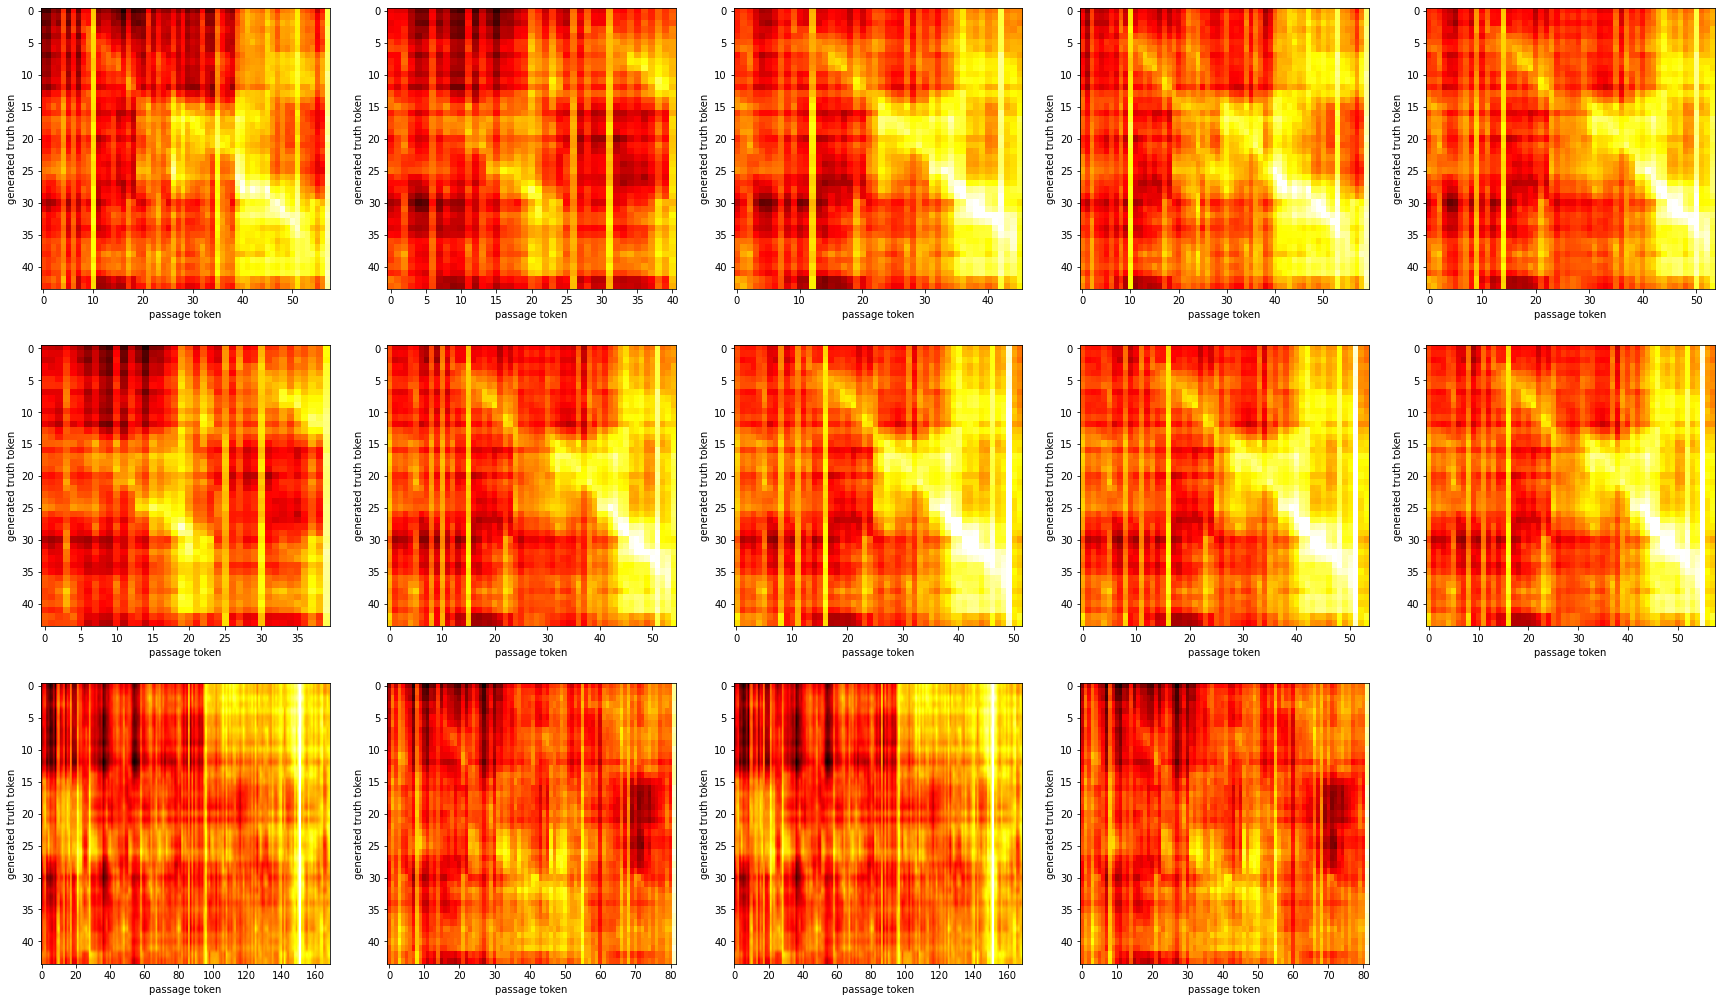

In [25]:
fig = plt.figure(figsize=(30, 30), facecolor="white")

for i in range(len(relevant_ranges)):
    plt.subplot(5, 5, i + 1)
    relevant_range = relevant_ranges[i]
    spliced_attn_matrix = avg_attn_matrix[:, relevant_range[0]:relevant_range[1]]
    spliced_attn_matrix_np = spliced_attn_matrix.numpy()
    
    np.save(f'example_matrix_{i}.npy', spliced_attn_matrix_np)
    im = plt.imshow(spliced_attn_matrix, cmap=plt.get_cmap('hot'), aspect='auto', vmin=-10, vmax=2)
    
    plt.xlabel('passage token')
    plt.ylabel('generated truth token')

-1.1517304
-2.1820424
-0.61390436
-0.59517896
-0.79952306
-1.5358268
-0.9595901
-0.34922308
-0.4930195
-0.5756873
-1.6418923
-2.2678573
-1.6418923
-2.2678573


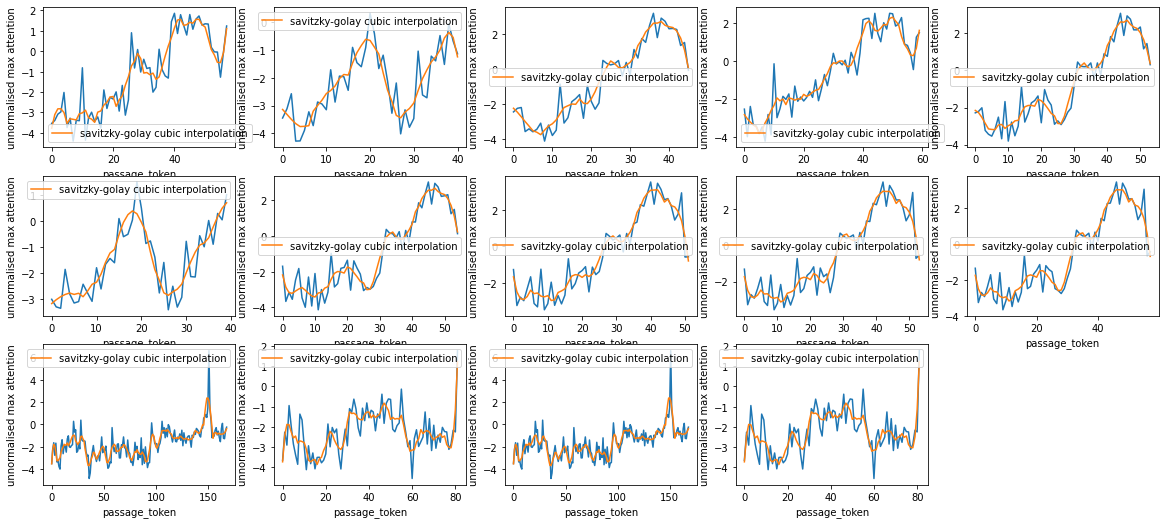

In [26]:
fig = plt.figure(figsize=(20, 15), facecolor="white")
savgols = []
for i in range(len(relevant_ranges)):
    plt.subplot(5, 5, i + 1)
    relevant_range = relevant_ranges[i]
    spliced_attn_matrix = avg_attn_matrix[:, relevant_range[0]:relevant_range[1]]
    
    maxpool = torch.max(spliced_attn_matrix, axis=0).values.cpu().numpy()
    minpool = torch.min(spliced_attn_matrix, axis=0).values.cpu().numpy()
    
    # m = maxpool - minpool
    m = maxpool
    # print(np.mean(m))
    savgol = scipy.signal.savgol_filter(m, 10, 3)
    print(np.mean(savgol))
    savgols.append(savgol)
    
    plt.plot(m)
    plt.plot(savgol, label='savitzky-golay cubic interpolation')
    plt.legend()
    plt.xlabel('passage_token')
    plt.ylabel('unnormalised max attention')
    

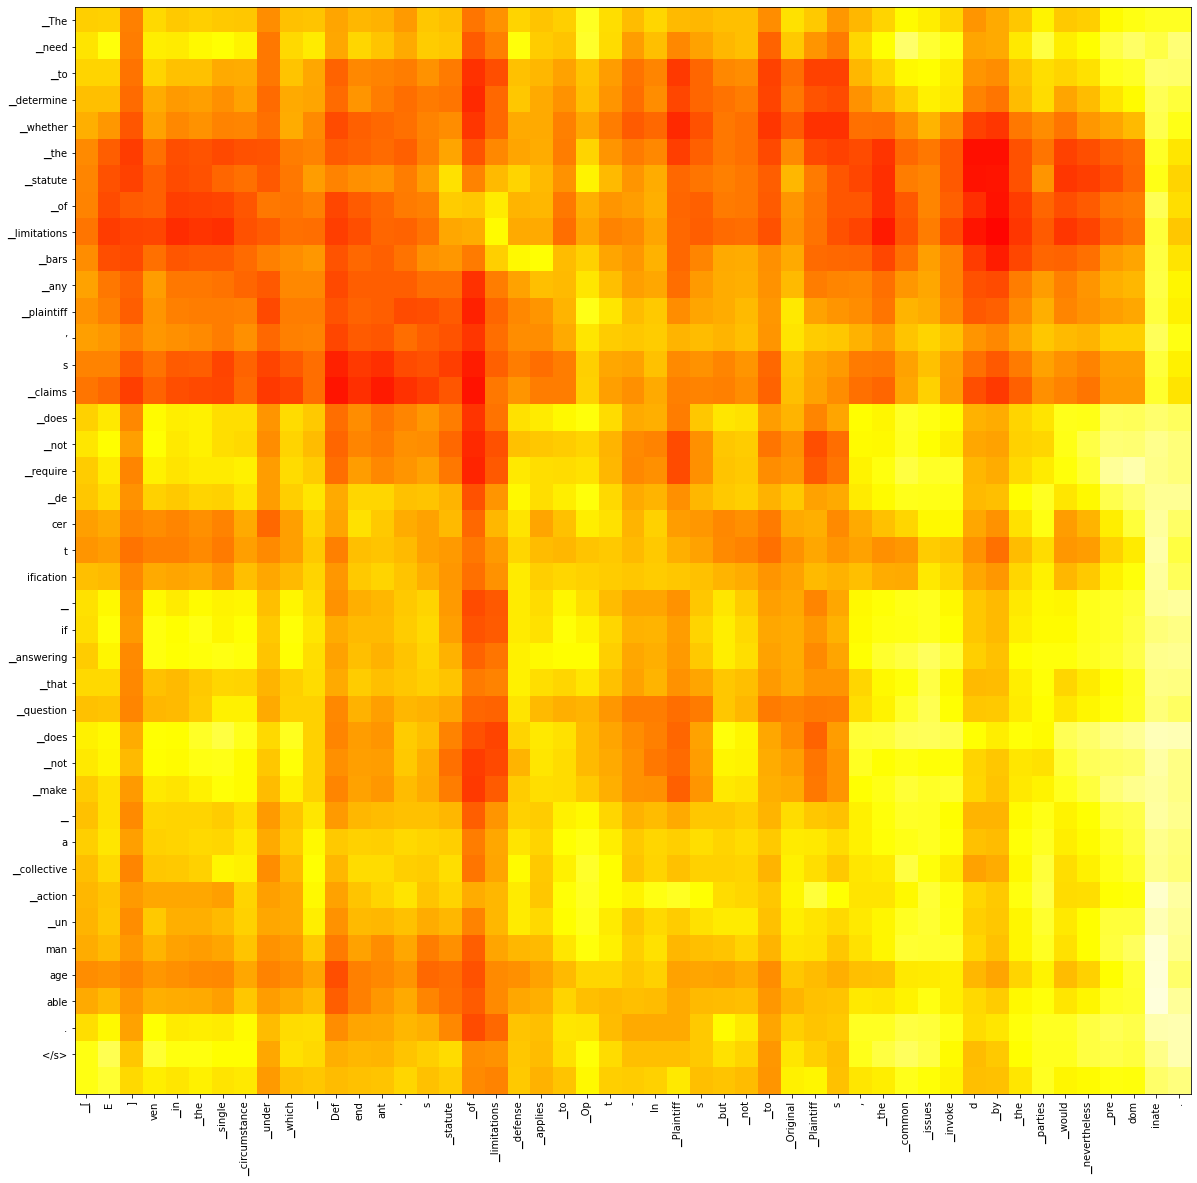

In [70]:
all_decoded_passage_tokens = tokenizer.convert_ids_to_tokens(context_ids_reshaped[0])
decoded_labels = tokenizer.convert_ids_to_tokens(labels[0])

i = 15

relevant_range = relevant_ranges[i]
spliced_attn_matrix = avg_attn_matrix[:, relevant_range[0]:relevant_range[1]]
relevant_passage_tokens = all_decoded_passage_tokens[relevant_range[0]:relevant_range[1]]

# spliced_attn_matrix = np.load('example_matrix_1.npy')

fig = plt.figure(figsize=(20, 20), facecolor="white")
ax = fig.add_subplot(111)

im = ax.imshow(spliced_attn_matrix, cmap=plt.get_cmap('hot'), aspect='auto', vmin=-10, vmax=2)

xticks = ax.set_xticks(range(len(relevant_passage_tokens)), rotation=90)
xlabels = ax.set_xticklabels(relevant_passage_tokens, rotation=90)

yticks = ax.set_yticks(range(len(decoded_labels)), rotation=90)
ylabels = ax.set_yticklabels(decoded_labels)


In [ ]:
i = 10

peaks, properties = find_peaks(savgols[i], width=3)
plt.plot(savgols[i])
plt.scatter(list(peaks), [savgols[i][idx] for idx in list(peaks)], color='red')

plt.vlines(x=peaks, ymin=savgols[i][peaks] - properties["prominences"],
           ymax = savgols[i][peaks], color = "C1")

plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")

### Visualise layer-head averaged cross-attention matrix

In [ ]:
# ALL RELEVANT PASSAGES
fig = plt.figure(figsize=(20, 10), facecolor="white")
ax = fig.add_subplot()
#ax.imshow(averaged_attention_matrix[:, :], cmap='hot', interpolation='nearest')
im = ax.imshow(avg_attn_matrix.cpu().numpy(), cmap=plt.get_cmap('hot'), aspect='auto', vmin=-10, vmax=0)
fig.colorbar(im)

In [ ]:
# ONLY FIRST PASSAGE RELEVANT 
fig = plt.figure(figsize=(20, 10), facecolor="white")
ax = fig.add_subplot()
#ax.imshow(averaged_attention_matrix[:, :], cmap='hot', interpolation='nearest')
im = ax.imshow(avg_attn_matrix.cpu().numpy(), cmap=plt.get_cmap('hot'), aspect='auto', vmin=-10, vmax=0)
fig.colorbar(im)

In [ ]:
# ALL PASSAGES IRRELEVANT
fig = plt.figure(figsize=(20, 10), facecolor="white")
ax = fig.add_subplot()
#ax.imshow(averaged_attention_matrix[:, :], cmap='hot', interpolation='nearest')
im = ax.imshow(avg_attn_matrix.cpu().numpy(), cmap=plt.get_cmap('hot'), aspect='auto', vmin=-10, vmax=0)
fig.colorbar(im)

In [ ]:
# FIRST PASSAGE RELEVANT
passage_len = context_mask.shape[2]
start = 1
end = 2


decoded_passage_tokens = tokenizer.convert_ids_to_tokens(context_ids_reshaped[0][(start*passage_len):(end*passage_len)])
decoded_labels = tokenizer.convert_ids_to_tokens(labels[0])

fig = plt.figure(figsize=(20, 20), facecolor="white")
ax = fig.add_subplot(111)
passage_1_sector = avg_attn_matrix[:, (start*passage_len):(end*passage_len)]
im = ax.imshow(passage_1_sector, cmap=plt.get_cmap('hot'), aspect='auto', vmin=-10, vmax=0)

ax.set_xticks(range(passage_len), rotation=90)
ax.set_xticklabels(decoded_passage_tokens, rotation=90)

ax.set_yticks(range(len(labels[0])), rotation=90)
ax.set_yticklabels(decoded_labels)

fig.colorbar(im)

## Obtaining the generative output score

In [ ]:
len(dataloader)

### Figure out prevalence of very confident, correct vs incorrect answers

In [ ]:
# only one context vector

exact_match_log_probabilities = []
incorrect_log_probabilities = []
exact_match_answers = []

for i, batch in tqdm(enumerate(dataloader)):
    
    (idx, _, _, context_ids, context_mask) = batch
    sequences = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                max_length=100,
                return_dict_in_generate=True,
                output_scores=True
            ).sequences

    
    for k, o in enumerate(sequences):
        ans = tokenizer.decode(o, skip_special_tokens=True)
        gold = eval_dataset.get_example(idx[k])['answers']
        score = ems(ans, gold)
        #print(score)
        # total += 1
        # exactmatch.append(score)
#         print("model generated output:")
#         print(ans)

#         print("")
#         print("ground truth:")
#         print(gold) 

    # print("extracting negative log probability ...")
    log_probability = model.obtain_log_generated_probability(
        input_ids=context_ids.cuda(),
        attention_mask=context_mask.cuda(),
        max_length=100

    )
    
    if score == True:
        exact_match_log_probabilities.append(log_probability.cpu().numpy())
        exact_match_answers.append(ans)
#         if len(exact_match_log_probabilities) >= 5:
#             print("exceeded five exact matches")
        
#         if len(exact_match_log_probabilities) >= 10:
#             print("exceeded ten exact matches")
    
    else:
        incorrect_log_probabilities.append(log_probability.cpu().numpy())
        
    if i >= 0:
        break


In [ ]:
# load from local
exact_match_log_probabilities = np.load("../numpy_drops/exact_matches_dev.npy")
incorrect_log_probabilities = np.load("../numpy_drops/incorrects_dev.npy")
rouge_match_log_probabilities = np.load("../numpy_drops/rouge_matches_dev.npy")

In [ ]:
with open("../numpy_drops/rouge_similarity_answers_dev_sampling", "rb") as f:
    rouge_matches = pickle.load(f)

len(rouge_matches)

In [ ]:
len([el for el in rouge_matches if el[2] == 1.0])

In [ ]:
zipped_rouge = list(zip(rouge_matches, rouge_match_log_probabilities))

In [ ]:
print("rouge match distribution")
print(len(rouge_match_log_probabilities))
print(np.mean(rouge_match_log_probabilities))
print(np.std(rouge_match_log_probabilities))

In [ ]:
print("exact match distribution")
print(len(exact_match_log_probabilities))
print(np.mean(exact_match_log_probabilities))
print(np.std(exact_match_log_probabilities))

In [ ]:
print("incorrect match distribution")
print(len(incorrect_log_probabilities))
print(np.mean(incorrect_log_probabilities))
print(np.std(incorrect_log_probabilities))

In [ ]:
fig = plt.figure(figsize=(8,8), facecolor="white")
ax = fig.add_subplot(111)
ax.scatter(list(range(len(incorrect_log_probabilities))), incorrect_log_probabilities, label="incorrects")
ax.scatter(list(range(len(rouge_match_log_probabilities))), rouge_match_log_probabilities, color="red", label="rouge corrects")
ax.scatter(list(range(len(exact_match_log_probabilities))), exact_match_log_probabilities, color="orange", label="exact matches")
ax.set_ylabel("log_sum_prob")
ax.legend()

In [ ]:
zipped_rouge = list(zip(rouge_matches, rouge_match_log_probabilities))

inexact_matches = [el for el in zipped_rouge if el[0][2] != 1.0]

inexact_match_log_probabilities = list(zip(*inexact_matches))[1]


In [ ]:
# rouge-l correctness
corrects_rouge = list(rouge_match_log_probabilities)
incorrects_rouge = list(incorrect_log_probabilities)

y_scores_rouge = corrects_rouge + incorrects_rouge
y_true_rouge = list(np.zeros(len(corrects_rouge)).astype(int)) + list(np.ones(len(incorrects_rouge)).astype(int))

# exact match correctness
corrects_exact = list(exact_match_log_probabilities)
incorrects_exact = list(incorrect_log_probabilities) + list(inexact_match_log_probabilities)

y_scores_exact = corrects_exact + incorrects_exact
y_true_exact = list(np.zeros(len(corrects_exact)).astype(int)) + list(np.ones(len(incorrects_exact)).astype(int))

In [ ]:
len(corrects_rouge) + len(incorrects_rouge)

In [ ]:
threshold = 0.003

label_scores = list(zip(y_true_rouge, y_scores_rouge))

predicted_positive = [el for el in label_scores if el[1] <= threshold]
predicted_negative = [el for el in label_scores if el[1] > threshold]

true_positive = len([el for el in predicted_positive if el[0] == 0])
false_positive = len([el for el in predicted_positive if el[0] == 1])

true_negative = len([el for el in predicted_negative if el[0] == 1])
false_negative = len([el for el in predicted_negative if el[0] == 0])

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)


print(f"precision: {precision}")
print(f"recall: {recall}")

In [ ]:
total_examples = len(rouge_match_log_probabilities) + len(incorrect_log_probabilities)

print(f"total examples: {total_examples}")

allowed_through = true_positive + false_positive

fraction_allowed_through = allowed_through / total_examples

print(f"fraction allowed through: {fraction_allowed_through}")

### PR curve

In [ ]:
def obtain_p_and_r(y_true, y_pred, thresholds):
    
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        label_scores = list(zip(y_true, y_pred))

        predicted_positive = [el for el in label_scores if el[1] <= threshold]
        predicted_negative = [el for el in label_scores if el[1] > threshold]

        true_positive = len([el for el in predicted_positive if el[0] == 0])
        false_positive = len([el for el in predicted_positive if el[0] == 1])

        true_negative = len([el for el in predicted_negative if el[0] == 1])
        false_negative = len([el for el in predicted_negative if el[0] == 0])

        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)

        precisions.append(precision)
        recalls.append(recall)
    
    return precisions, recalls
        

In [ ]:
thresholds = np.linspace(0, 1, 101)

precisions_rouge, recalls_rouge = obtain_p_and_r(y_true_rouge, y_scores_rouge, thresholds)
precisions_exact, recalls_exact = obtain_p_and_r(y_true_exact, y_scores_exact, thresholds)

precisions_rouge = [1.0] + precisions_rouge + [0.0]
recalls_rouge = [0.0] + recalls_rouge + [1.0]

precisions_exact = [1.0] + precisions_exact + [0.0]
recalls_exact = [0.0] + recalls_exact + [1.0]

In [ ]:
fig = plt.figure(figsize=(8,8), facecolor="white")
fig.suptitle("Rouge-L PR curve", fontsize=16)
ax = fig.add_subplot(111)

ax.step(recalls_rouge, precisions_rouge, label="rouge-l confidences", where='post')
plt.axhline(1 - sum(y_true_rouge) / len(y_true_rouge), xmin=0.0, xmax=0.95, linestyle='--', color="red", label="rouge-l coin flip")
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("recall")
ax.set_ylabel("precision")
ax.text(0.1, 0.1, "auc: {:.4f}".format(auc(recalls_rouge, precisions_rouge)), bbox=dict(facecolor='white', alpha=0.5))
ax.legend()

In [ ]:
fig = plt.figure(figsize=(8,8), facecolor="white")
fig.suptitle("Exact match PR curve", fontsize=16)
ax = fig.add_subplot(111)

# ax.plot(recalls_exact, precisions_exact)
ax.step(recalls_exact, precisions_exact, label="exact match confidences", where='post')
plt.axhline(1 - sum(y_true_exact) / len(y_true_exact), xmin=0.0, xmax=0.95, linestyle='--', color="red", label="exact match coin flip")
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("recall")
ax.set_ylabel("precision")
ax.text(0.15, 0.5, "auc: {:.4f}".format(auc(recalls_exact, precisions_exact)), bbox=dict(facecolor='white', alpha=0.5))
ax.legend()

### inspect some generated sentences

In [ ]:
for i, batch in enumerate(dataloader):
    (idx, labels, _, context_ids, context_mask) = batch
    for j in range(context_ids.shape[1]):

            print("====")
            print(j)
            context = tokenizer.decode(context_ids[0][j])
            print(context)
            if j >= 0:
                break
    
    if i > 0:
        break


In [ ]:
[el for el in rouge_matches if el[2] == 1.0][:20]

#### 

### Obtain example generated vs ground truth outputs

In [ ]:
# only one context vector
for i, batch in enumerate(dataloader):
    
    if i == 7:
        print(f"training example: {i}")
        (idx, _, _, context_ids, context_mask) = batch
        sequences = model.generate(
                    input_ids=context_ids.cuda(),
                    attention_mask=context_mask.cuda(),
                    max_length=10,
                    return_dict_in_generate=True,
                    output_scores=True
                ).sequences

        print(sequences)
        for k, o in enumerate(sequences):
            ans = tokenizer.decode(o, skip_special_tokens=True)
            gold = eval_dataset.get_example(idx[k])['answers']
            score = ems(ans, gold)
            #print(score)
            # total += 1
            # exactmatch.append(score)
            print("model generated output:")
            print(ans)

            print("")
            print("ground truth:")
            print(gold) 
        
        print("extracting negative log probability ...")
        log_probability = model.obtain_log_generated_probability(
            input_ids=context_ids.cuda(),
            attention_mask=context_mask.cuda(),
            max_length=10
            
        )
        
        print(score)
        
        print(log_probability)
        
        break


In [ ]:
softmax = torch.nn.Softmax(dim=1)
total_log_prob = 0
for i in range(len(outputs.scores)):
    print(torch.log(torch.max(softmax(outputs.scores[i]))))
    total_log_prob -= torch.log(torch.max(softmax(outputs.scores[i])))

total_log_prob

## Comparing tokenizers

In [ ]:
bert_tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
t5_tokenizer = transformers.T5Tokenizer.from_pretrained('t5-base')

In [ ]:
input_sequence = "Welcome to the HuggingFace Library"

In [ ]:
bert_tokenized = bert_tokenizer(input_sequence, return_tensors='pt')
t5_tokenized = t5_tokenizer(input_sequence, return_tensors='pt')

print(bert_tokenized.input_ids)
print("===")
print(t5_tokenized.input_ids)

In [ ]:
print(bert_tokenizer.decode(bert_tokenized.input_ids[0]))
print("===")
print(t5_tokenizer.decode(t5_tokenized.input_ids[0]))

In [ ]:
bert_tokenizer.convert_ids_to_tokens(bert_tokenized.input_ids[0])

In [ ]:
t5_tokenizer.convert_ids_to_tokens(t5_tokenized.input_ids[0])

In [ ]:
z = torch.randn((2, 4))

In [ ]:
msk = torch.tensor([[True, False, True], [False, True, False]])
msk2 = torch.tensor([[True, False, True, True]])

In [ ]:
z

In [ ]:
z.masked_fill(msk2 == 0, 0.0)

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained('t5-small')
import torch

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [ ]:
input_ids = tokenizer.encode("summarise: I am originally from siberia, where the sky is green", return_tensors="pt")  # Batch size 1


In [ ]:
outputs = model.generate(input_ids, 
                          return_dict_in_generate=True, 
                          output_scores=True, 
                          num_beams=1,
                          do_sample=True,
                          top_k=3,
                          temperature=1.0
                          )


outputs.sequences

In [ ]:
scores = outputs.scores

In [ ]:
torch.topk(scores[2][0], k=3).indices

In [ ]:
len(scores)

In [ ]:
softmax = torch.nn.Softmax(dim=1)
softmax(scores[0])

In [ ]:
scores[4][0]

In [ ]:
scores[4][0][sequence[0][5]]

In [ ]:
torch.argmax(scores[11])

In [ ]:
ans = []
for i in range(len(scores)):
    sfx = softmax(scores[i])
    ans.append(sfx[0][sequence[0][i + 1]])

In [ ]:
y_true = np.array([0, 0, 1, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8, 0.9])

precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)


In [ ]:
threshold = 0.35

label_scores = list(zip(y_true, y_scores))

predicted_positive = [el for el in label_scores if el[1] >= threshold]
predicted_negative = [el for el in label_scores if el[1] < threshold]

true_positive = len([el for el in predicted_positive if el[0] == 1])
false_positive = len([el for el in predicted_positive if el[0] == 0])

true_negative = len([el for el in predicted_negative if el[0] == 0])
false_negative = len([el for el in predicted_negative if el[0] == 1])

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print(precision)
print(recall)


In [ ]:
thresholds

In [ ]:
precisions

In [ ]:
recalls

## Ad hoc cells

In [7]:
import json

In [17]:
compose_path = "/home/divy/casetext-ml-datasets/fid_reader_distill_question_data/notebooks/compose_fid_train_scored.json"

train_examples = load_data(
                            compose_path,
                            global_rank=0,
                            world_size=1,
                            )

In [18]:
len(train_examples)

3000

In [20]:
truncated_train_examples = train_examples[:300]

In [24]:
with open("/home/divy/casetext-ml-datasets/fid_reader_distill_question_data/notebooks/compose_fid_truncated_truncated_train.json", "w") as fw:
    json.dump(truncated_train_examples, fw, indent=2)
